# Humo(u)r


**"You know that scene in Animal House, it is a fellow playing folk music on a guitar, and John Belushi picks up the guitar and destroys it...Well, the British comedian would want to play a folk singer. We want to play the failure."**

--Stephen Fry (<a href='http://lybio.net/tag/stephen-fry-on-american-vs-british-comedy-transcription/'>interview+transcript</a>)

The differences between British and American humor can be hard to pin down. As Stephen Fry has captured in the quote above, generally British comedy has a grim fatalism that contrasts with American optimism. Despite these differences, many British shows have developed American cult followings (Monty Python, Coupling, Fawlty Towers) and have even inspired successful crossovers, most famously The Office. 

To help me find more British-y comedies, I wanted to figure out whether I could train a an LSTM recurrent neural network to distinguish British from American humor. To minimize the influence of topic, I'll be training the model on transcripts from the UK and US Office. Theoretically, this trained neural network could be used to recommend American Anglophiles new English TV shows that have a British sense of humor (and the reverse, though I've personally never met any British Americanophiles ;) ) or be extended to making recommendations based on other styles of writing.


Kudos to this <a href='https://www.youtube.com/watch?v=Zyv4jGWEzxY&t=6s'>Youtube criticism video</a> for the initial inspiration, Cory Stephenson for advice on using LSTMs and this super helpful <a href='http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/'>tutorial on creating LSTMs in Keras</a>

# Game plan
Ok so the game plan for me then is to

1. Obtain a corpus of British and American documents to train the neural network on.
1. Identify and remove unique words in the text (slang, names, places, various entities) that could be used to distinguish shows and replace them with a generic identifier (xxNamexx). This is so the network doesn't just learn to focus on particular characters, places, etc. and instead extracts the shows' senses of humor. 
2. Format the text into workable chunks. Chunks of size 200 words should be good
3. Train neural networks to predict whether a show is British or American
4. See whether the network can make accurate predictions about other TV shows

I'll start by loading some basic packages

In [102]:
%matplotlib inline
import os
import numpy as np
import pandas as pd

import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

np.random.seed(7)

# 1. Obtain Training Corpus

Because British shows are <a href='https://www.youtube.com/watch?v=OT7TR3Td6KQ'>notoriously short</a>, I'll be combining The Office UK with Peep Show to get some extra data

* http://www.springfieldspringfield.co.uk/episode_scripts.php?tv-show=the-office-us
* http://www.springfieldspringfield.co.uk/episode_scripts.php?tv-show=the-office-uk
* http://www.springfieldspringfield.co.uk/episode_scripts.php?tv-show=peep-show-2003

In [3]:
us_folders=['office_us']
uk_folders=['office_uk','peep_show']

And let's try to make sure the classifier doesn't just capitalize on differences in English vs. American spelling

How long should the passages be?

In [5]:
parse_size=200

In [6]:
uk_data=[]
uk_show=[]
for fold_name in uk_folders:
    uk_fold=os.path.join('data',fold_name)
    curr_files=os.listdir(uk_fold)
    curr_files=[i for i in curr_files if i[-3:]=='txt']
    for fname in curr_files:
        curr_fname=os.path.join(uk_fold,fname)
        with open(curr_fname,'rb') as curr_f:
            temp=replace_strings(curr_f.read().lower())
            uk_curr_text=unicode(temp.decode('utf-8'))
            uk_show.append(fold_name)
            uk_data.append(uk_curr_text)
        

In [7]:
sum([len(i)/(parse_size*5) for i in uk_data]) # 5 is ~ average word length

1300

In [8]:
us_data=[]
us_show=[]
for fold_name in us_folders:
    us_fold=os.path.join('data',fold_name)
    curr_files=os.listdir(us_fold)
    curr_files=[i for i in curr_files if i[-3:]=='txt']    
    for fname in curr_files:
        curr_fname=os.path.join(us_fold,fname)
        with open(curr_fname,'rb') as curr_f:
            temp=replace_strings(curr_f.read().lower())
            us_curr_text=unicode(temp.decode('utf-8'))
            us_show.append(fold_name)
            us_data.append(us_curr_text)

In [9]:
sum([len(i)/(parse_size*5) for i in us_data])

1516

# 2. Remove jargon

And now of course I don't want the network to just pick out different words used by the shows--I want it to identify American and British wordplay. So first I'll normalize any spelling or slang differences using the replace_strings() function

In [4]:
def replace_strings(x):
    replace_dic={" '":" ", \
                "okay":"ok",\
                 "Okay":"ok",\
                "\n":" ",\
                "apologise":"apologize",\
                "humour":"humor",\
                 "colour":"color",\
                 "flavour":"flavor",\
                 "favour":"favor",\
                 "labour":"labor",\
                 "neighbour":"neighbor",\
                 "favourite":"favorite",\
                 "centre":"center",\
                 "fibre":"fiber",\
                 "litre":"liter",\
                 "theatre":"theater",\
                 "organise":"organize",\
                 "recognise":"recognize",\
                 "realise":"realize",\
                 "civilisation":"civilization",\
                 "analyse":"analyze",\
                 "defence":"defense",\
                 "offence":"offense",\
                 "licence":"license",\
                 "mum":"mom",\
                 "arsehole":"asshole",\
                 "tenner":'ten',\
                 "lads":"guys",\
                 "quid":"buck",\
                 "telly":"TV",\
                 " loo ": "bathroom ",\
                 " loo.":" bathroom.",\
                 "wanker ":"bastard ",\
                 "wanking ":"screwing ",\
                 "tits":"boobs",\
                 "wank ":"bastard ",\
                 "pint":"beer",\
                 "prick":"dick",\
                 "snog":"kiss",\
                 "crisps":"fries",\
                 "lazer":"laser",\
                 "twat":"jerk",
                 "shag":"screw"\
                 
                }
    for i in replace_dic.keys():
        x=x.replace(i,replace_dic[i])
    return x


And I'm going to use a TF-IDF transformation to idnetify words that are common to one category but not the other (likely to be proper nouns)

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf_words=[]
for j in range(1,302,20):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=1,
                                       max_features=j,
                                       stop_words='english')

    tfidf_values=tfidf_vectorizer.fit_transform([' '.join(us_data), \
                                             ' '.join(uk_data)]
                                           )
    tfidf_words.append(tfidf_vectorizer.get_feature_names())
    
    print 'New Words for TF-IDF='+str(j)
    if len(tfidf_words)>1:
        print [i for i in tfidf_words[-1] if i not in tfidf_words[-2]]
    else:
        print tfidf_words
    

New Words for TF-IDF=1
[[u'dwight']]
New Words for TF-IDF=21
[u'angela', u'cos', u'darryl', u'dobby', u'dunder', u'erin', u'gabe', u'gareth', u'jez', u'kelly', u'kevin', u'mifflin', u'phyllis', u'schrute', u'scranton', u'soph', u'sophie', u'stanley', u'suze', u'toby']
New Words for TF-IDF=41
[u'angus', u'arse', u'bollocks', u'cece', u'cock', u'corrigan', u'elena', u'fucked', u'gail', u'gerard', u'halpert', u'holly', u'ian', u'jo', u'mose', u'nellie', u'philly', u'sabre', u'scott', u'senator']
New Words for TF-IDF=61
[u'bloke', u'bullshit', u'california', u'ceo', u'deangelo', u'dobs', u'employee', u'erm', u'jlb', u'learned', u'lice', u'loads', u'mall', u'mural', u'packer', u'sarah', u'todd', u'toni', u'val', u'zahra']
New Words for TF-IDF=81
[u'blimey', u'dickhead', u'dundies', u'halloween', u'hay', u'lager', u'lf', u'luke', u'named', u'paedo', u'pennsylvania', u'phillip', u'printers', u'sofa', u'sorted', u'strangler', u'swindon', u'tallahassee', u'truck', u'wuphf']
New Words for TF-IDF

Ok so we start off strong with names and then there's a mix of proper nouns and various particular terms. I'm going to remove the all words in the first 100 and then the proper nouns in the 100-300.

In [43]:
# will need to revise this by hand if update data
pronouns=['cornell','keenan','tallahassee','paula','philadelphia ','shirley','todd', \
          'valerie','aberdeen','brandon','athlead','blake','camilla','nick','orgazoid', \
          'rolf','strangler','columbus','dave','obama','binghamton','drake','enya','beesly','iris', \
          'justine','nelson','bez','eva','bristol','lamar','nate','walter','anton','bertram','gerrard' \
          ,'oliver','norris','robert','michael','scott','pbs','barney','daryl','glee','keith','ravi', \
          'sarah','sweeney','lipton','natalie','nance','jordan','heather','malcolm', \
          'kapoor','hastings','jim','jeremy','andy','nashua','steffan','hannon', \
         'cally','helene','corfu','saz','mikanos','gettysburg','isabel','dartmouth','joshy']

words_to_remove=tfidf_words[5]+pronouns

In [12]:
from spacy.en import English
nlp = English()

In [13]:
def proc_text(curr_data,words_to_remove):
    parsed_data = nlp(curr_data)
    lemma_data=[w.lemma_ for w in parsed_data if (w.pos_!='PUNCT' and w.pos_!='NUM' and w.pos_!='SPACE')]
    rem_data=['xxNamexx' if w in words_to_remove else w for w in lemma_data]
    return rem_data

In [14]:
us_data_proc=[' '.join(proc_text(doc,words_to_remove)) for doc in us_data]
uk_data_proc=[' '.join(proc_text(doc,words_to_remove)) for doc in uk_data]

And now uk/us_data_proc contains the text with the show-specific words replaced by xxNamexx

# 3. Data formatting

Now turn these texts into numbers that the algorithm can actually use. I'm going to use the CountVectorize function to find the 5000 most frequent words to use.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
n_features=5000
tf_vectorizer = CountVectorizer(min_df=2,max_features=n_features,stop_words='english')
tf_vectorizer.fit(us_data_proc+uk_data_proc)
tf_words=tf_vectorizer.get_feature_names()
freqs=np.reshape(np.asarray(np.mean(tf_vectorizer.transform(us_data_proc+uk_data_proc),axis=0)),(n_features,))
tf_words=[j[0] for j in sorted([i for i in zip(tf_words,freqs)],key=lambda x:x[1])[::-1]]

The section below will turn each word in the top 5000 into a number corresponding to its ranked frequency

In [17]:
num_vec_us_fname='num_vec_data_us.pkl'
if not os.path.exists(num_vec_us_fname):
    us_data_vec=[[tf_words.index(w)+1 for w in proc_text(doc,words_to_remove) if w in tf_words] for doc in us_data]
    with open(num_vec_us_fname,'wb') as f:
        pkl.dump(us_data_vec,f)
else:
    with open(num_vec_us_fname,'rb') as f:
        us_data_vec=pkl.load(f)    

In [18]:
num_vec_uk_fname='num_vec_data_uk.pkl'
if not os.path.exists(num_vec_uk_fname):
    uk_data_vec=[[tf_words.index(w)+1 for w in proc_text(doc,words_to_remove) if w in tf_words] for doc in uk_data]
    with open(num_vec_uk_fname,'wb') as f:
        pkl.dump(uk_data_vec,f)
else:
    with open(num_vec_uk_fname,'rb') as f:
        uk_data_vec=pkl.load(f)

And this section will divide the transcripts into sections about **parse_size** words. It'll also create the class labels, such that UK=1, US=0

In [19]:
x_data=[]
y_data=[]

for doc in us_data_vec:
    win_range=range(0,len(doc),parse_size)+[len(doc)]
    for i in range(0,len(win_range)-1):
        x_data.append(doc[win_range[i]:win_range[i+1]])
        y_data.append(0)

for doc in uk_data_vec:
    win_range=range(0,len(doc),parse_size)+[len(doc)]
    for i in range(0,len(win_range)-1):
        x_data.append(doc[win_range[i]:win_range[i+1]])
        y_data.append(1)

In [20]:
print np.mean(y_data)
print len(x_data)

0.461105904405
1067


Finally, this section will just make sure each sequence is the same length

In [21]:
from keras.preprocessing import sequence

Using TensorFlow backend.


In [22]:
max_review_length=max([len(i) for i in x_data])
x_data2 = sequence.pad_sequences(x_data, maxlen=max_review_length)

# 4. Train models

## LSTM models

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

In [24]:
from sklearn.cross_validation import train_test_split

In [30]:
X_train,X_test,y_train,y_test=train_test_split(x_data2,y_data)

## One layer model

First I'm going to try out a single layer model with dropout. This model should be able to exploit any sequential dependencies that are useful for classify transcripts.

In [37]:
embedding_vecor_length = 32
model_single = Sequential()
model_single.add(Embedding(n_features+1, embedding_vecor_length, input_length=max_review_length))
model_single.add(Dropout(0.2))
model_single.add(LSTM(100))
model_single.add(Dropout(0.2))
model_single.add(Dense(1, activation='sigmoid'))
model_single.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_single.summary())
model_single.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=8, batch_size=64)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_6 (Embedding)          (None, 200, 32)       160032      embedding_input_6[0][0]          
____________________________________________________________________________________________________
dropout_13 (Dropout)             (None, 200, 32)       0           embedding_6[0][0]                
____________________________________________________________________________________________________
lstm_8 (LSTM)                    (None, 100)           53200       dropout_13[0][0]                 
____________________________________________________________________________________________________
dropout_14 (Dropout)             (None, 100)           0           lstm_8[0][0]                     
___________________________________________________________________________________________

In [67]:
# Final evaluation of the model
scores = model_single.evaluate(X_test, y_test, verbose=0)
print 'Single-Layer Model Accuracy'
print("Accuracy: %.2f%%" % (scores[1]*100))

Single-Layer Model Accuracy
Accuracy: 92.51%


The one layer model has pretty good accuracy! Let's try out two layers to see if there's information in longer-term depenencies.

## Two layer stacked model

In [33]:
embedding_vecor_length = 32
model_stack = Sequential()
model_stack.add(Embedding(n_features+1, embedding_vecor_length, input_length=max_review_length))
model_stack.add(Dropout(0.2))
model_stack.add(LSTM(100,return_sequences=True, input_shape=(max_review_length, n_features+1)))
model_stack.add(Dropout(0.2))
model_stack.add(LSTM(100))
model_stack.add(Dropout(0.2))
model_stack.add(Dense(1, activation='sigmoid'))
model_stack.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_stack.summary())
model_stack.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=8, batch_size=64)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_4 (Embedding)          (None, 200, 32)       160032      embedding_input_4[0][0]          
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 200, 32)       0           embedding_4[0][0]                
____________________________________________________________________________________________________
lstm_5 (LSTM)                    (None, 200, 100)      53200       dropout_8[0][0]                  
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 200, 100)      0           lstm_5[0][0]                     
___________________________________________________________________________________________

In [68]:
# Final evaluation of the model
scores = model_stack.evaluate(X_test, y_test, verbose=0)
print 'Two-Layer Model Accuracy'
print("Accuracy: %.2f%%" % (scores[1]*100))

Two-Layer Model Accuracy
Accuracy: 95.51%


The two-layer LSTM performs marginally more accurately, though performance was already pretty high. It may be worth testing out some other architectures (another layer, different number of hidden nodes), but given that this network is doing pretty damn good, let's test the models out on some novel data to see whether there are more salient differences.

# 5. Classifying new data

Let's test the networks on two shows that were also made by the creators of The US and UK Offices, respectively: Parks and Recreation and Extras

In [57]:
# run on individual strings
def clean_text(text,pn,tf_words):
    # Takes in text, tokenizes, replaces proper nouns in pn with xxNamexx, lower cases, lemmatizes and encodes
    # as numeric using tf_words
    text=text.lower()
    return [tf_words.index(w)+1 for w in proc_text(text,pn) if w in tf_words]

In [39]:
test_folders=['parks_rec','extras']
test_data=[]
test_show=[]
for fold_name in test_folders:
    test_fold=os.path.join('data',fold_name)
    curr_files=os.listdir(test_fold)
    curr_files=[i for i in curr_files if i[-3:]=='txt']    
    for fname in curr_files:
        curr_fname=os.path.join(test_fold,fname)
        with open(curr_fname,'rb') as curr_f:
            temp=replace_strings(curr_f.read().lower())
            test_curr_text=unicode(temp.decode('utf-8'))
            test_show.append(fold_name)
            test_data.append(test_curr_text)

Define show specific names to turn into xxnamexx, so the vectorizer recognizes them

In [54]:
parks_rec_pn=['pawnee','washington','leslie','knope','tom','haverford','ron','swanson','april','ludgate', \
             'andy','dwyer','ben','wyatt','jerry','gergich','ken','donna','meagle','johnny','gryzzl','sweetums', \
              'ann','perkins','chris','traeger','diane','craig','middlebrooks','lucy','jean-ralphio','perd', \
              'jeremy','jamm','sapperstein','joe','ethel','levondrius' \
             ]

extra_pn=['andy','millman','maggie','jacobs','darren','lamb','barry','greg','lindley-jones','bbc','robert','ross' \
         ,'ben','eastenders','johnny','damon','ronnie','corbett','john','paul','jackson','fran','shaun','joe', \
          'david','richard','jackie','michael','maureen'
         ]

test_pn={'parks_rec':parks_rec_pn,'extras':extra_pn}

In [84]:
test_x_data=[]
test_episode=[]
test_y_data=[]
for i,show_name in enumerate(test_show):
    test_data_vec=clean_text(test_data[i],test_pn[show_name],tf_words)

    win_range=range(0,len(test_data_vec),parse_size)+[len(doc)]
    for j in range(0,len(win_range)-1):
        test_x_data.append(test_data_vec[win_range[j]:win_range[j+1]])
        if show_name=='parks_rec':
            test_y_data.append(0)
        else:
            test_y_data.append(1)
        test_episode.append(show_name+str(i))

In [65]:
max_review_length=max([len(i) for i in test_x_data])
test_x_data2 = sequence.pad_sequences(test_x_data, maxlen=max_review_length)

In [66]:
scores = model_single.evaluate(test_x_data2, test_y_data, verbose=0)
print 'Single-Layer Model Accuracy'
print("Accuracy: %.2f%%" % (scores[1]*100))

scores = model_stack.evaluate(test_x_data2, test_y_data, verbose=0)
print 'Two-Layer Model Accuracy'
print("Accuracy: %.2f%%" % (scores[1]*100))

Single-Layer Model Accuracy
Accuracy: 66.87%
Two-Layer Model Accuracy
Accuracy: 86.75%


Whereas the Two-Layer model was previously *slightly* better than the One-Layer model, taking longer-term sequential dependencies into account really helped it capture more general notions of British and American humor. Let's also see how well the networks estimated the probability of episodes being American or British

In [71]:
single_test_proba = model_single.predict_proba(test_x_data2)
double_test_proba = model_stack.predict_proba(test_x_data2)

166/166 [==============================] - 2s     


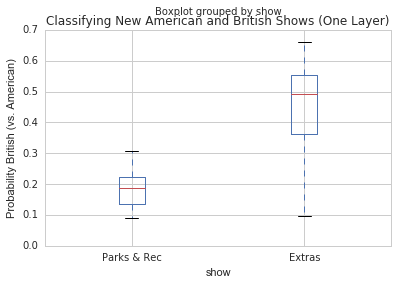

In [110]:
single_df=pd.DataFrame({'proba':np.reshape(single_test_proba,len(single_test_proba),1), \
                        'episode':test_episode,'show':test_y_data})
single_df.groupby('episode').mean().boxplot(column='proba',by='show')
plt.ylabel('Probability British (vs. American)')
plt.xticks(range(1,3),['Parks & Rec','Extras'])
plt.title('Classifying New American and British Shows (One Layer)')

The One-Layer model does a decent job at recognizing Parks and Rec is American and Extras is British. But there are some huge interquartile ranges for Extras. Let's see how the Two-Layer model does.

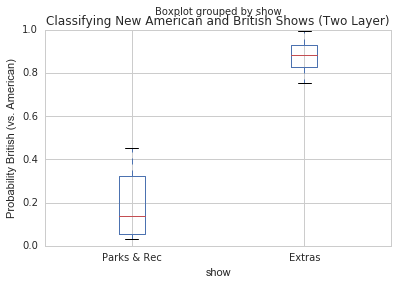

In [111]:
double_df=pd.DataFrame({'proba':np.reshape(double_test_proba,len(double_test_proba),1), \
                        'episode':test_episode,'show':test_y_data})
double_df.groupby('episode').mean().boxplot(column='proba',by='show')
plt.ylabel('Probability British (vs. American)')
plt.xticks(range(1,3),['Parks & Rec','Extras'])
plt.title('Classifying New American and British Shows (Two Layer)')

The Two-Layer model does a much better job at distinguishing British and American humor. The substantial improvement brought by adding the second LSTM layer suggests that long-term dependencies really help distinguish which shows are British and which are American (and not just vocabulary or word-to-word conditional probabilities).

# Does it generalize?

Finally, let's make sure I didn't just create a network that can only distinguish the works of Mark Schur and Ricky Gervais (although that in itself would perhaps have some usefulness). For this I'm going to try to classify Friends and Fawlty Towers as British and American.

In [146]:
test2_folders=['fawlty_towers','friends']
test2_data=[]
test2_show=[]
for fold_name in test_folders:
    test_fold=os.path.join('data',fold_name)
    curr_files=os.listdir(test_fold)
    curr_files=[i for i in curr_files if i[-3:]=='txt']    
    for fname in curr_files:
        curr_fname=os.path.join(test_fold,fname)
        with open(curr_fname,'rb') as curr_f:
            temp=replace_strings(curr_f.read().lower())
            test2_curr_text=unicode(temp.decode('utf-8'))
            test2_show.append(fold_name)
            test2_data.append(test2_curr_text)

Define show specific names to turn into xxnamexx, so the vectorizer recognizes them

In [147]:
fawlty_pn=['fawlty','basil','sybil','polly','sherman','manuel','terry','hugh','gowen','tibbs','gatsby','audrey',\
          'melbury','reilly','lurphy','stubbs','alan','peignoir','hutchinson','walt','richards','abbott','arrad',\
          'leeman','roger','alice','']

friends_pn=['ross','gellar','rachel','monica','phoebe','bouffe','marcel','chandler','bing','joey','tribiani', \
           'mindy','barry','paul','janice','carol','susan','alan','george','stephanopolous','angela','bob', \
           'aurora','jill','goodacre','david','paolo']

test2_pn={'fawlty_towers':fawlty_pn,'friends':friends_pn}

In [148]:
test2_x_data=[]
test2_episode=[]
test2_y_data=[]
for i,show_name in enumerate(test2_show):
    test_data_vec=clean_text(test2_data[i],test2_pn[show_name],tf_words)

    win_range=range(0,len(test_data_vec),parse_size)+[len(doc)]
    for j in range(0,len(win_range)-1):
        test2_x_data.append(test_data_vec[win_range[j]:win_range[j+1]])
        if show_name=='friends':
            test2_y_data.append(0)
        else:
            test2_y_data.append(1)
        test2_episode.append(show_name+str(i))

In [149]:
max_review_length=max([len(i) for i in test2_x_data])
test2_x_data2 = sequence.pad_sequences(test2_x_data, maxlen=max_review_length)

In [154]:
double_test2_proba = model_stack.evaluate(test2_x_data2,test2_y_data,verbose=0)
print 'Two-Layer Model Accuracy'
print("Accuracy: %.2f%%" % (scores[1]*100))

Two-Layer Model Accuracy
Accuracy: 95.51%


In [155]:
double_test2_proba = model_stack.predict_proba(test2_x_data2,verbose=0)

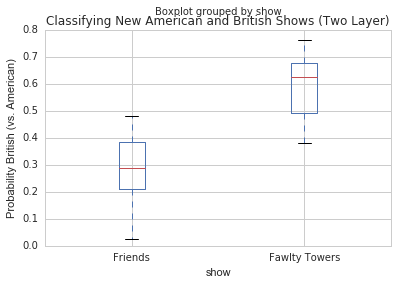

In [157]:
double_df=pd.DataFrame({'proba':np.reshape(double_test2_proba,len(double_test2_proba),1), \
                        'episode':test2_episode,'show':test2_y_data})
double_df.groupby('episode').mean().boxplot(column='proba',by='show')
plt.ylabel('Probability British (vs. American)')
plt.xticks(range(1,3),['Friends','Fawlty Towers'])
plt.title('Classifying New American and British Shows (Two Layer)')

And the Two-Layer network correctly found that Friends was more American and Fawlty Towers was more British! It is worth noting here that there's a bit more uncertainty--these boxplots are much closer to .5 (what you'd expect by random guessing) and their interquartile ranges overlap--But the network is for the most part recognizing that Friends is an American comedy and Fawlty Towers is British!

# Wrap up

Using a Two-Layer LSTM recurrent neural network trained to distinguish the US and UK versions of The Office, I was able to classify whether a TV show had a British or American sense of humor. I want to emphasize the importance of cleaning and normalizing the original text data; without it, all I would've had was a British slang detector. Anglo/Americano-philes can use my trained network to find TV shows, plays, comedians, etc from other countries that match their sense of humor.